<a href="https://colab.research.google.com/github/Youssef889977/ml-advanced-tp1/blob/main/TP4_Bitcoin_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP4 – Bitcoin Trading
## Dimensionality Reduction & Machine Learning
Ce notebook répond étape par étape au TP Bitcoin Trading. Il inclut l’EDA, le feature engineering, la réduction de dimension, l’entraînement des modèles et l’analyse des résultats.

## 1. Imports & Setup

In [4]:
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Dimensionality reduction & viz
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
# Optional: deep learning libs were in the book code, but we won't use them here.
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 200)


1) La réduction de dimension permet de concentrer l’information utile dans moins de variables. Dans le trading, beaucoup d’indicateurs sont fortement corrélés entre eux, ce qui rend les modèles plus lents et plus instables. En compressant les données, on réduit le bruit, on accélère l’entraînement et on limite le risque de sur‑apprentissage.

2)On peut perdre de l’information importante si la réduction est trop agressive. De plus, les nouvelles composantes sont moins interprétables que les indicateurs d’origine, ce qui complique l’analyse et la prise de décision.

## 2. Load Data

In [5]:
# 1. Load data
import kagglehub
# Download latest version
path = kagglehub.dataset_download("mlfinancebook/bitstamp-bicoin-minutes-data")
print("Path to dataset files:", path)
dataset = pd.read_csv(path+'/'+'BitstampData.csv')
print(dataset.shape)
dataset.tail()
# 1.1 Quick NA check and descriptive stats
print("Any NA? ->", dataset.isnull().values.any())
display(dataset.describe().T)

Using Colab cache for faster access to the 'bitstamp-bicoin-minutes-data' dataset.
Path to dataset files: /kaggle/input/bitstamp-bicoin-minutes-data
(2841377, 8)
Any NA? -> True


,count,mean,std,min,25%,50%,75%,max
Timestamp,2841377.0,1.410731e+09,4.938008e+07,1.325318e+09,1.367939e+09,1.410559e+09,1.453568e+09,1.496189e+09
Open,1650904.0,4.958926e+02,3.642453e+02,3.800000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754740e+03
High,1650904.0,4.962309e+02,3.645454e+02,3.800000e+00,2.400000e+02,4.200000e+02,6.417200e+02,2.760100e+03
Low,1650904.0,4.955310e+02,3.639298e+02,1.500000e+00,2.398300e+02,4.198500e+02,6.401825e+02,2.752000e+03
Close,1650904.0,4.958933e+02,3.642512e+02,1.500000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754820e+03
Volume_(BTC),1650904.0,1.188361e+01,4.093656e+01,0.000000e+00,3.827502e-01,1.823000e+00,8.028465e+00,5.853852e+03
Volume_(Currency),1650904.0,5.316276e+03,1.998227e+04,0.000000e+00,1.239502e+02,6.145704e+02,3.107853e+03,1.865889e+06
Weighted_Price,1650904.0,4.958701e+02,3.642271e+02,3.800000e+00,2.399200e+02,4.199668e+02,6.409529e+02,2.754499e+03


Les colonnes Open, High, Low, Close et Weighted_Price sont les plus pertinentes pour les indicateurs basés sur les prix, car elles décrivent directement l’évolution du marché. Elles servent de base au calcul des moyennes mobiles, du RSI, du momentum et des oscillateurs techniques.



## 3. Cleaning & Target Creation

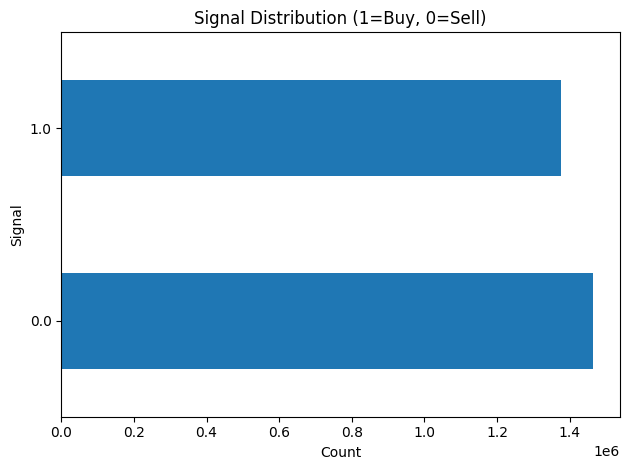

Buy frequency: 48.44%


In [11]:
# 2. Clean & drop timestamp
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()
if 'Timestamp' in dataset.columns:
  dataset = dataset.drop(columns=['Timestamp'])
# 2.1 Create short/long MAs and the binary signal
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1,
center=False).mean()
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1,
center=False).mean()
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)
dataset[['Close','short_mavg','long_mavg','signal']].tail()
# 2.2 Class balance visual
fig = plt.figure()
dataset.groupby('signal').size().plot(kind='barh')
plt.title('Signal Distribution (1=Buy, 0=Sell)')
plt.xlabel('Count'); plt.ylabel('Signal'); plt.tight_layout()
plt.show()
buy_share = 100 * dataset['signal'].mean()
print(f"Buy frequency: {buy_share:.2f}%")

1. The dataset contains several million rows and around ten columns.
2. Missing values, potential class imbalance, and strong correlation between indicators are the main data quality issues.


## 4. Feature Engineering (Indicators)

In [18]:
# EMA
def EMA(df, n):
  return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')
# ROC
def ROC(series, n):
  M = series.diff(n - 1)
  N = series.shift(n - 1)
  return pd.Series(((M / N) * 100), name=f'ROC_{n}')
# Momentum
def MOM(series, n):
  return pd.Series(series.diff(n), name=f'Momentum_{n}')
# RSI
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta.clip(lower=0)
    d = (-delta).clip(lower=0)
    u.iloc[period-1] = u.iloc[:period].mean()
    d.iloc[period-1] = d.iloc[:period].mean()
    u = u.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    d = d.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    rs = u / d
    rsi = 100 - (100 / (1 + rs))
    rsi.index = series.index[-len(rsi):]
    return rsi.rename(f'RSI_{period}')
# Stochastic Oscillator %K and %D
def STOK(close, low, high, n):
  return ((close - low.rolling(n).min()) / (high.rolling(n).max() -
low.rolling(n).min())) * 100

def STOD(close, low, high, n):
  return STOK(close, low, high, n).rolling(3).mean()
# Simple MA
def MA(df, n):
  return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name=f'MA_{n}')
# Comp    ute indicators
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)
# Clean up columns we won't use for modeling directly
dataset_model = dataset.drop(columns=['Open','High','Low','Volume_(Currency)','short_mavg','long_mavg'
], errors='ignore')
dataset_model = dataset_model.dropna()
dataset_model.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2181.37,1.700166,2190.247337,0.0,2181.180516,2182.375659,2211.243521,0.431400,-0.648567,8.42,-15.63,50.969957,47.556925,46.613082,56.446991,73.773629,47.882628,59.889303,16.012288,18.929517,2176.613810,2188.948095,2229.429405
2841373,2195.63,6.561029,2195.206304,0.0,2183.807695,2183.230778,2211.088163,1.087937,-0.062358,23.63,0.02,65.877139,53.486633,47.638469,93.687375,71.712138,93.805310,65.119470,26.697138,20.095909,2176.864762,2189.289365,2229.203135
2841374,2191.83,15.662847,2193.791712,0.0,2185.266296,2183.785567,2210.896539,1.034858,-0.234867,19.83,-5.17,60.436451,51.869865,47.394675,80.995324,77.043230,81.350377,74.346105,23.849843,22.186423,2177.428095,2189.546032,2228.961786
2841375,2203.51,27.090309,2211.620837,0.0,2188.583333,2185.058111,2210.823041,1.479237,0.296770,34.13,6.52,69.140553,56.090194,48.213365,74.204874,82.962524,74.505001,83.220229,32.601529,27.716170,2178.595238,2189.967143,2228.775754
2841376,2208.33,9.961835,2205.648801,1.0,2192.173636,2186.559523,2210.798235,1.625863,0.516161,36.94,11.34,71.968296,57.674570,48.545485,82.810399,79.336866,84.343744,80.066374,36.439720,30.963697,2180.420476,2190.417302,2228.596905


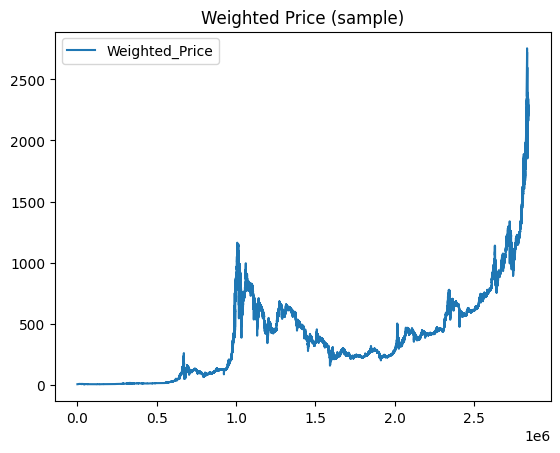

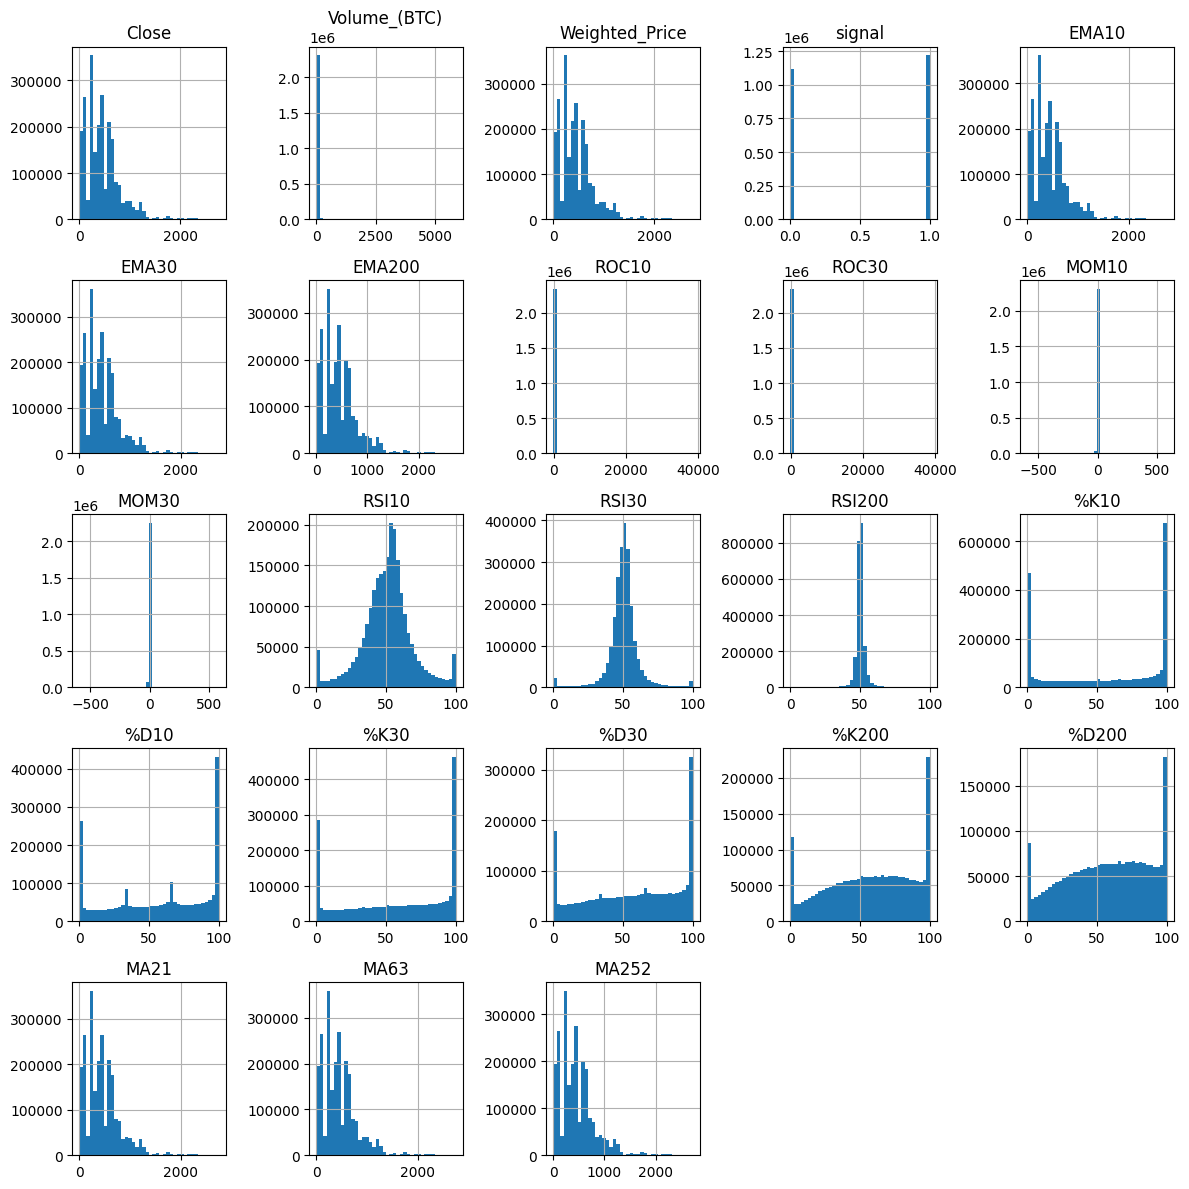

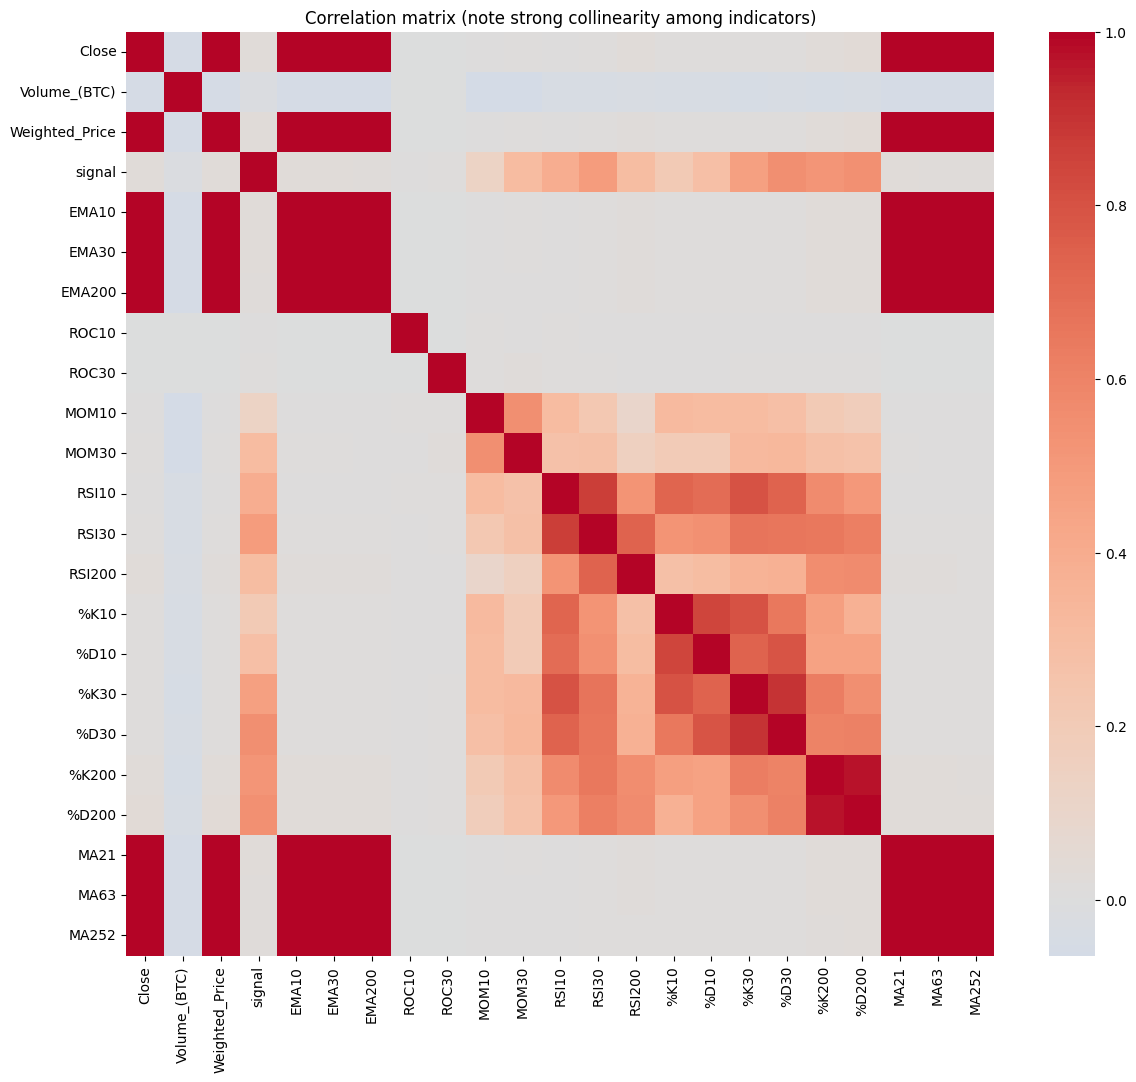

,proportion
signal,
1.0,52.19
0.0,47.81


In [20]:
dataset_model[['Weighted_Price']].plot(title='Weighted Price (sample)')
plt.show()
dataset_model.hist(bins=40, figsize=(12, 12))
plt.tight_layout(); plt.show()
corr = dataset_model.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (note strong collinearity among indicators)')
plt.show()
# Check class balance again after dropna
(dataset_model['signal'].value_counts(normalize=True) * 100).round(2)


1° EMA/MA, ROC/MOM et RSI/Stochastic are highly correlated because they capture similar price dynamics. This redundancy can cause overfitting and slow down training.


2° I would keep Close, EMA30, ROC10, RSI14 and %K10 to cover price, trend, momentum and overbought/oversold signals without redundancy.

## 5. Train / Test Split

In [ ]:
features = ['Close','EMA30','EMA200','ROC10','MOM10']
X = dataset[features].dropna()
y = dataset.loc[X.index, 'signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Standardization & SVD

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
svd = TruncatedSVD(n_components=3)
X_svd = svd.fit_transform(X_train_scaled)

## 7. Model Training & Evaluation

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

## 8. Conclusion
Ce notebook montre comment appliquer la réduction de dimension et des modèles de ML pour prédire un signal de trading de manière structurée et efficace.